In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scsavailability as scs
    
import statsmodels.api as sm
from scipy import stats


from scsavailability import features as feat, model as md, plotting as pt

2020-12-10 09:00:55,236 - NumExpr defaulting to 8 threads.


In [2]:
path = 'C:/Users/Jamie.williams/OneDrive - Newton Europe Ltd/Castle Donnington/Data/'

In [3]:
at = pd.read_csv(path+'active_totes_20201123.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-2511.csv')
fa = pd.read_csv(path + 'scs_tote_matched.csv')

In [4]:
at = feat.pre_process_AT(at)

Running: Function "pre_process_AT" (id=1639982981616) was called 1 times


In [5]:
av = feat.pre_process_av(av)

Running: Function "pre_process_av" (id=1639982985072) was called 1 times


In [6]:
fa = feat.preprocess_faults(fa,remove_same_location_faults = True)

Running: Function "preprocess_faults" (id=1639982983920) was called 1 times
Running: Function "load_module_lookup" (id=1639982984928) was called 1 times
duplicated location faults removed - max duration kept


In [7]:
fa_floor = feat.floor_shift_time_fa(fa, shift=0)

Time shifted by 0Minutes


In [24]:
fa_sel = feat.fault_select(fa_floor, fault_select_options = {'Tote Colour':['Grey']})
                                                            
fa_agg = feat.faults_aggregate(fa_sel,fault_agg_level= None, agg_type = 'count')

Running: Function "faults_aggregate" (id=1639983170032) was called 3 times


In [25]:
av_sel,at_sel = feat.av_at_select(av, at, remove_high_AT = True,availability_select_options = None)

av_agg = feat.aggregate_availability(av_sel, agg_level = None)
at_agg = feat.aggregate_totes(at_sel, agg_level = None)

Running: Function "aggregate_availability" (id=1639983170464) was called 3 times


In [61]:
df = feat.merge_av_fa_at(av_agg ,at_df=at_agg, fa_df = fa_agg, target = 'Grey Tote Loss' ,faults=False, totes = True, agg_level = None,remove_0=True)

Datasets merged


In [62]:
df.head(3)

,timestamp,Grey Tote Loss,TOTES
0,2020-11-18 11:00:00,0.121705,57.146915
1,2020-11-18 12:00:00,0.142833,58.247505
2,2020-11-18 13:00:00,0.130401,58.786807


In [64]:
X,y = md.gen_feat_var(df)
y=1-y

In [66]:
X_train, X_test, y_train, y_test = md.split(X,y,test_size=0.3,random_state=42)

RF_mdl,predictions_RF=md.run_RF_model(X_train, X_test, y_train, y_test,num_trees=100, criterion = 'mse', max_depth=None, dtree=False)

Linear_mdl,predictions_LM,Coeff,fit_metrics = md.run_LR_model(X_train, X_test, y_train, y_test)

XGB_mdl,predictions_XGB,Importance_XGB = md.run_XGB_model(X_train, X_test, y_train, y_test)

maxf = None

X_sel_rf = md.select_features(X, y, RF_mdl, thres = -np.inf, max_feat = maxf)

X_sel_lm = md.select_features(X, y, Linear_mdl, thres = -np.inf, max_feat = maxf)

X_sel_XGB = md.select_features(X, y, XGB_mdl, thres = -np.inf, max_feat = maxf)

#X_train, X_test, y_train, y_test = md.split(X_sel_lm,y,test_size=0.3,random_state=101)

#Linear_mdl,predictions_LM,Coeff,fit_metrics = md.run_LR_model(X_train, X_test, y_train, y_test)


cv_R2 = md.cross_validate_r2(Linear_mdl, X_sel_lm, y, n_folds = 10, shuffle = True, random_state = 101)

cv_R2 = md.cross_validate_r2(RF_mdl, X_sel_rf, y, n_folds = 10, shuffle = True, random_state = 101)

cv_R2 = md.cross_validate_r2(XGB_mdl, X_sel_XGB, y, n_folds = 10, shuffle = True, random_state = 101)

#md.stats_model(Linear_mdl,X_test,y_test)

Feature Importance Ranking: 
 
    Importance Feature
0         1.0   TOTES

Regression Metrics: 
 
           RF Metrics
MAE         0.044011
MSE         0.004419
RMSE        0.066479
MAPE%       5.240000
ACC%       94.760000
OOB        -0.635226
R2_Train    0.764667
R2_Pred    -1.042209 

Feature Importance Ranking: 
 
    Importance Feature
0         1.0   TOTES

Regression Metrics: 
 
          XGB Metrics
MAE        0.0527918
MSE       0.00776998
RMSE       0.0881475
MAPE%           6.23
ACC%           93.77
OOB              N/A
R2_Train    0.996003
R2_Pred     -2.59049 


Number of Selected Features:1 


Number of Selected Features:1 


Number of Selected Features:1 


Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1      -0.798503
2       0.130414
3       0.009903
4       0.164523
5       0.049485
6       0.061824
7       0.013519
8      -0.076534
9       0.025865
10      0.069791
Mean   -0.034971
STD     0.262183

Cross Validation Scores RandomForestRegressor(

KeyError: 0

                                 OLS Regression Results                                
Dep. Variable:         Grey Tote Loss   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              1480.
Date:                Thu, 10 Dec 2020   Prob (F-statistic):                    3.05e-54
Time:                        09:53:18   Log-Likelihood:                          17.563
No. Observations:                  83   AIC:                                     -33.13
Df Residuals:                      82   BIC:                                     -30.71
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

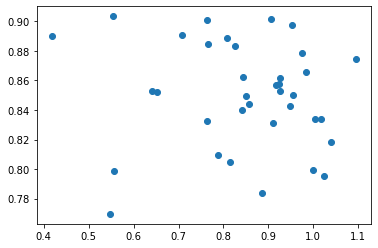

In [47]:
model = sm.OLS(y_train,X_train)
results = model.fit()
print(results.summary())

X_new = sm.add_constant(X_test)
y_prediction =  results.predict(X_test)

plt.scatter(y_prediction,y_test)

from sklearn.metrics import r2_score
print(r2_score(y_prediction,y_test))

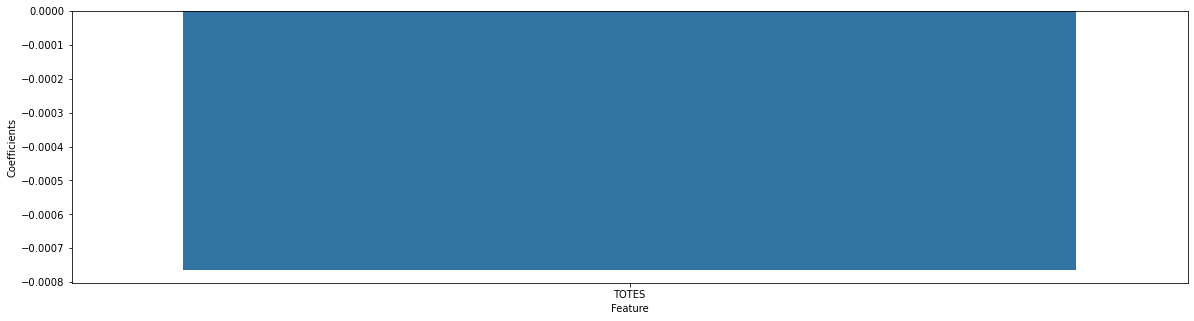

In [48]:
plt.figure(figsize=(20,5))
sns.barplot(data=Coeff, x='Feature',y = 'Coefficients')

In [49]:
Coeff

,Coefficients,Feature
0,-0.000764,TOTES


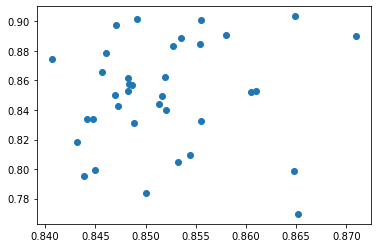

In [50]:
plt.scatter(predictions_LM,y_test)